# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
from backtesting import Strategy

## Getting the Data

In [6]:
XAUUSD = load_data()

In [7]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [8]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


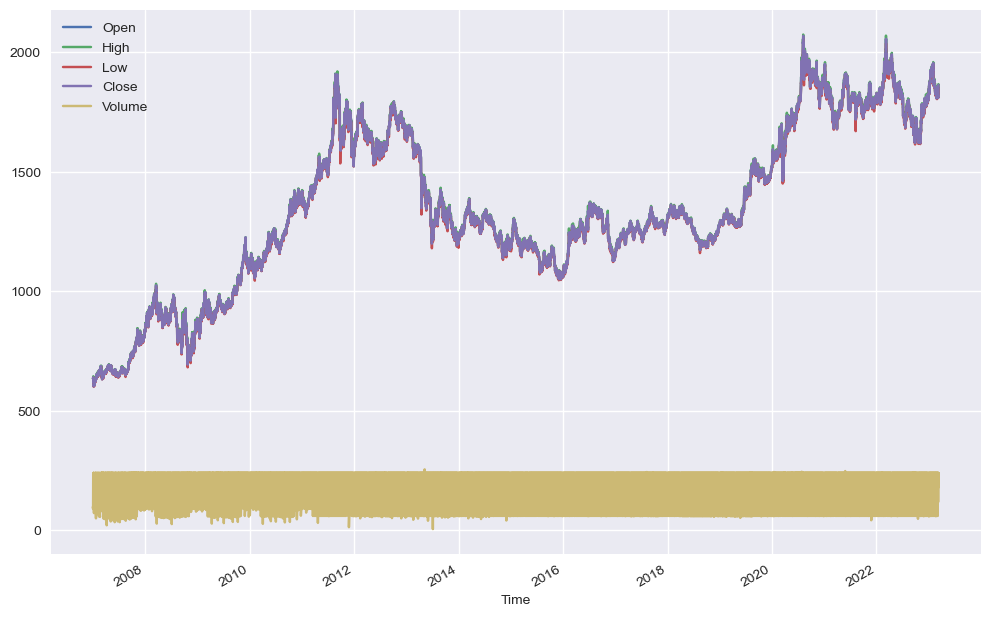

In [9]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
strategy = Linear_Regression
account_size = 1000
folder_ML_Strategy = 'Linear Regression'

In [12]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.account_size = account_size

    def Prepare(self, lags=0):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=0):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=self.account_size , margin= 1/100)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        self.Predict()
        result_test = self.Backtest(self.data_test)
       

        return result_train, result_test

## TF D1

In [13]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'


In [14]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [15]:
train , test = ml.Run()

### In-Sample Backtesting

In [16]:
train

Start                     2007-01-02 00:00:00
End                       2019-12-30 00:00:00
Duration                   4745 days 00:00:00
Exposure Time [%]                   99.950617
Equity Final [$]                     1886.729
Equity Peak [$]                      2282.379
Return [%]                            88.6729
Buy & Hold Return [%]              137.008776
Return (Ann.) [%]                      4.0292
Volatility (Ann.) [%]               12.404396
Sharpe Ratio                          0.32482
Sortino Ratio                        0.472956
Calmar Ratio                         0.107397
Max. Drawdown [%]                  -37.516951
Avg. Drawdown [%]                   -2.204034
Max. Drawdown Duration     3052 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     141.492008
Worst Trade [%]                    141.492008
Avg. Trade [%]                    

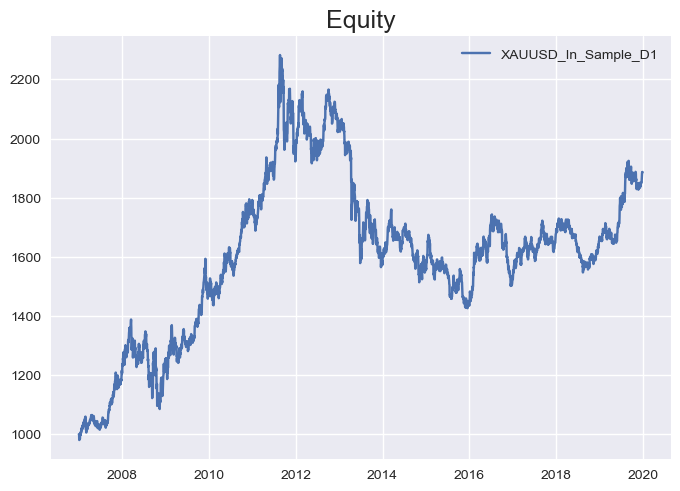

In [17]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [18]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                     1271.693
Equity Peak [$]                      1509.443
Return [%]                            27.1693
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                    6.309001
Volatility (Ann.) [%]               23.242499
Sharpe Ratio                         0.271442
Sortino Ratio                        0.404306
Calmar Ratio                         0.215284
Max. Drawdown [%]                  -29.305512
Avg. Drawdown [%]                   -5.114846
Max. Drawdown Duration      946 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      17.419177
Worst Trade [%]                     17.419177
Avg. Trade [%]                    

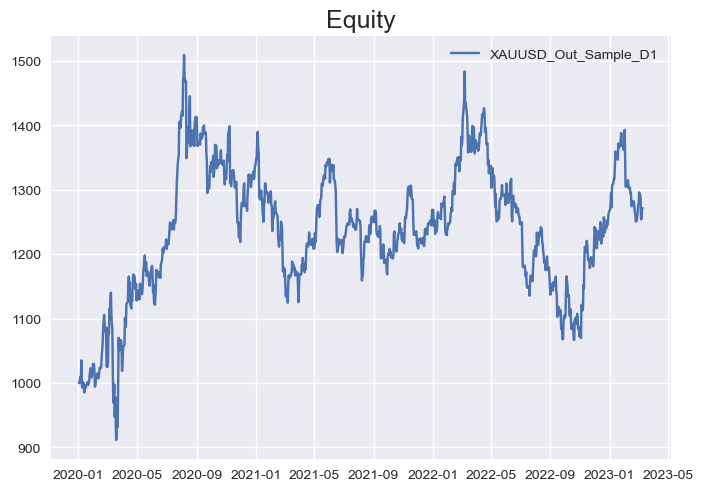

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [24]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'


In [25]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [26]:
train , test = ml.Run()

### In-Sample Backtesting

In [27]:
train

Start                     2007-01-01 04:00:00
End                       2019-12-31 16:00:00
Duration                   4747 days 12:00:00
Exposure Time [%]                   99.990416
Equity Final [$]                     1885.845
Equity Peak [$]                      2273.025
Return [%]                            88.5845
Buy & Hold Return [%]              139.055748
Return (Ann.) [%]                    4.024852
Volatility (Ann.) [%]               12.483449
Sharpe Ratio                         0.322415
Sortino Ratio                        0.469394
Calmar Ratio                         0.106552
Max. Drawdown [%]                  -37.773716
Avg. Drawdown [%]                   -1.225933
Max. Drawdown Duration     3052 days 20:00:00
Avg. Drawdown Duration       26 days 19:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     139.272199
Worst Trade [%]                    139.272199
Avg. Trade [%]                    

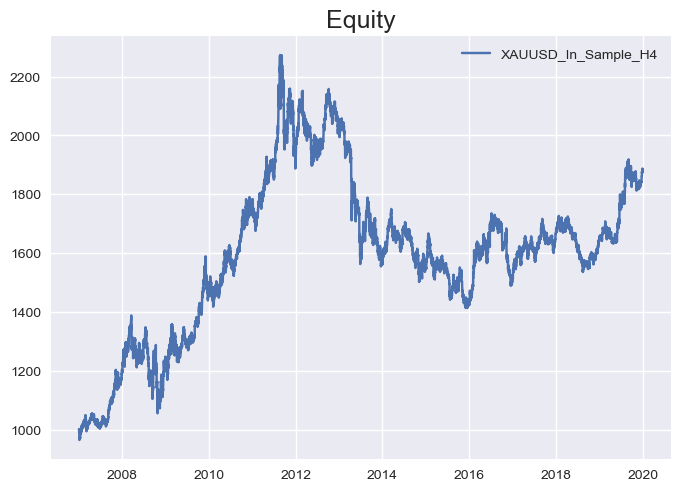

In [28]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [29]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                      1343.85
Equity Peak [$]                      1550.043
Return [%]                             34.385
Buy & Hold Return [%]               22.615843
Return (Ann.) [%]                    7.551304
Volatility (Ann.) [%]               22.809668
Sharpe Ratio                         0.331057
Sortino Ratio                        0.499847
Calmar Ratio                         0.260391
Max. Drawdown [%]                  -28.999905
Avg. Drawdown [%]                   -2.404948
Max. Drawdown Duration      945 days 20:00:00
Avg. Drawdown Duration       27 days 11:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      22.634591
Worst Trade [%]                     22.634591
Avg. Trade [%]                    

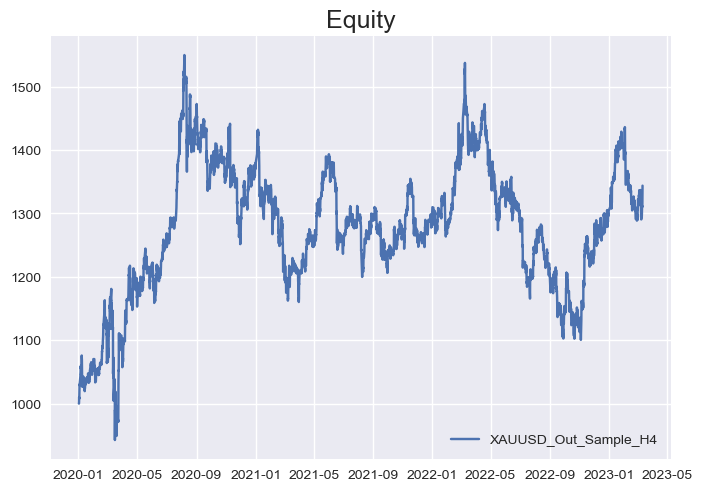

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [31]:
filename_train = f'result_{TF}_In_Sample.csv'

In [32]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [33]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [34]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [35]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'


In [36]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [37]:
train , test = ml.Run()

### In-Sample Backtesting

In [38]:
train

Start                     2007-01-01 01:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 19:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                     1462.925
Equity Peak [$]                      2448.963
Return [%]                            46.2925
Buy & Hold Return [%]               138.69256
Return (Ann.) [%]                    2.394735
Volatility (Ann.) [%]               12.946132
Sharpe Ratio                         0.184977
Sortino Ratio                        0.263931
Calmar Ratio                         0.044467
Max. Drawdown [%]                  -53.854427
Avg. Drawdown [%]                   -0.891683
Max. Drawdown Duration     3038 days 15:00:00
Avg. Drawdown Duration       13 days 21:00:00
# Trades                                 3305
Win Rate [%]                        57.488654
Best Trade [%]                       5.261569
Worst Trade [%]                    -11.373657
Avg. Trade [%]                    

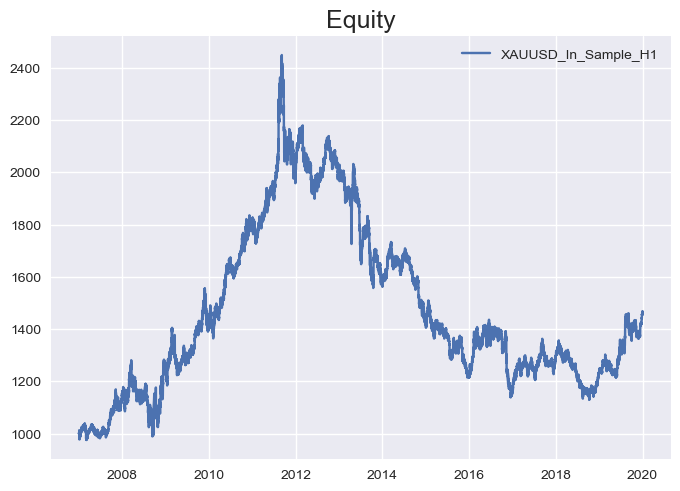

In [39]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [40]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                     1628.579
Equity Peak [$]                       1798.77
Return [%]                            62.8579
Buy & Hold Return [%]               22.749066
Return (Ann.) [%]                    12.94904
Volatility (Ann.) [%]               21.392964
Sharpe Ratio                         0.605294
Sortino Ratio                        0.978844
Calmar Ratio                         0.477704
Max. Drawdown [%]                  -27.106802
Avg. Drawdown [%]                   -1.480821
Max. Drawdown Duration      553 days 07:00:00
Avg. Drawdown Duration       11 days 17:00:00
# Trades                                  655
Win Rate [%]                        57.099237
Best Trade [%]                       4.250873
Worst Trade [%]                      -5.96921
Avg. Trade [%]                    

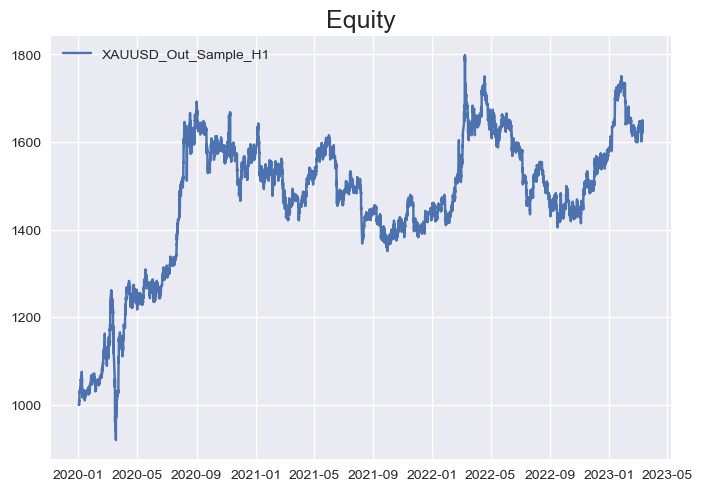

In [41]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [42]:
filename_train = f'result_{TF}_In_Sample.csv'

In [43]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [44]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [45]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [46]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'


In [47]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [48]:
train , test = ml.Run()

### In-Sample Backtesting

In [49]:
train

Start                     2007-01-01 00:30:00
End                       2019-12-31 21:00:00
Duration                   4747 days 20:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                     3902.095
Equity Peak [$]                      4015.125
Return [%]                           290.2095
Buy & Hold Return [%]              138.769304
Return (Ann.) [%]                    8.826585
Volatility (Ann.) [%]                7.571442
Sharpe Ratio                         1.165773
Sortino Ratio                          1.8697
Calmar Ratio                         0.832043
Max. Drawdown [%]                  -10.608326
Avg. Drawdown [%]                   -0.326698
Max. Drawdown Duration     1159 days 05:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                41453
Win Rate [%]                        60.256194
Best Trade [%]                       3.226737
Worst Trade [%]                     -6.166761
Avg. Trade [%]                    

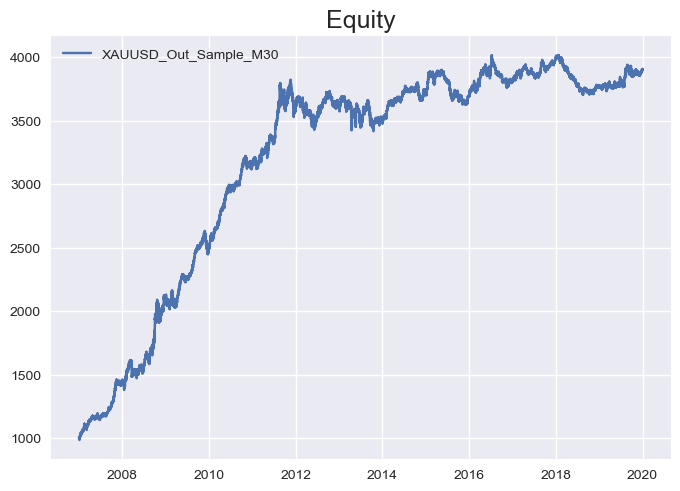

In [50]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [51]:
test

Start                     2020-01-01 23:30:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                     2566.363
Equity Peak [$]                      2590.847
Return [%]                           156.6363
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   27.082258
Volatility (Ann.) [%]                18.73762
Sharpe Ratio                         1.445341
Sortino Ratio                         2.81741
Calmar Ratio                         2.166556
Max. Drawdown [%]                  -12.500144
Avg. Drawdown [%]                   -0.725044
Max. Drawdown Duration      256 days 12:30:00
Avg. Drawdown Duration        2 days 20:49:00
# Trades                                10524
Win Rate [%]                        59.692132
Best Trade [%]                       2.868117
Worst Trade [%]                     -5.163814
Avg. Trade [%]                    

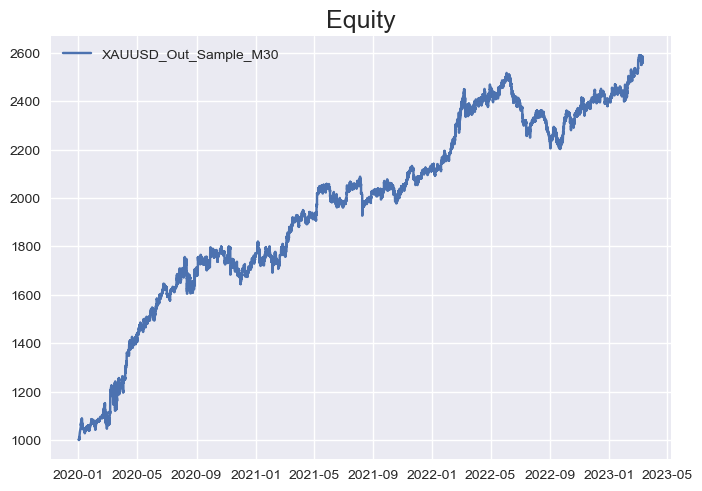

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [53]:
filename_train = f'result_{TF}_In_Sample.csv'

In [54]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [55]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [56]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [57]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'


In [58]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [59]:
train , test = ml.Run()

### In-Sample Backtesting

In [60]:
train

Start                     2014-09-23 13:15:00
End                       2019-12-31 21:30:00
Duration                   1925 days 08:15:00
Exposure Time [%]                   99.998394
Equity Final [$]                     1598.564
Equity Peak [$]                      1613.666
Return [%]                            59.8564
Buy & Hold Return [%]               23.687411
Return (Ann.) [%]                    7.487245
Volatility (Ann.) [%]               12.252155
Sharpe Ratio                         0.611096
Sortino Ratio                        0.933117
Calmar Ratio                         0.316414
Max. Drawdown [%]                  -23.662781
Avg. Drawdown [%]                   -0.450661
Max. Drawdown Duration      746 days 23:45:00
Avg. Drawdown Duration        4 days 06:53:00
# Trades                                58859
Win Rate [%]                        61.822321
Best Trade [%]                       1.582846
Worst Trade [%]                     -2.589536
Avg. Trade [%]                    

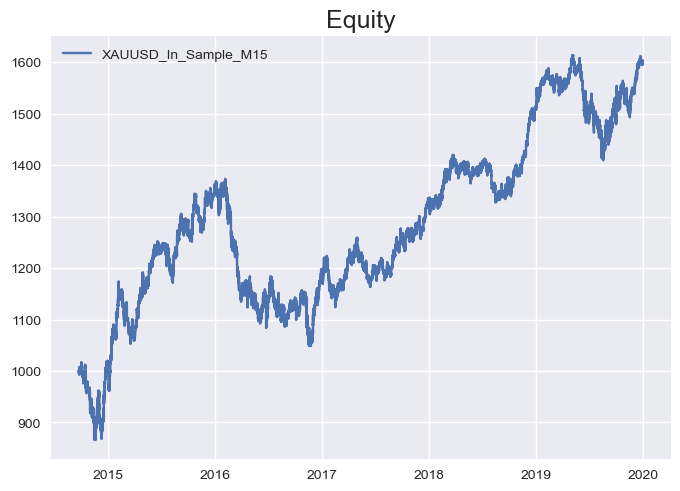

In [61]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [62]:
test

Start                     2020-01-01 23:15:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                     3237.326
Equity Peak [$]                      3255.687
Return [%]                           223.7326
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                   34.849654
Volatility (Ann.) [%]               18.573554
Sharpe Ratio                         1.876305
Sortino Ratio                        3.937318
Calmar Ratio                         2.047631
Max. Drawdown [%]                  -17.019496
Avg. Drawdown [%]                   -0.394771
Max. Drawdown Duration      186 days 06:15:00
Avg. Drawdown Duration        1 days 06:53:00
# Trades                                36772
Win Rate [%]                         62.90384
Best Trade [%]                       1.662467
Worst Trade [%]                     -3.472768
Avg. Trade [%]                    

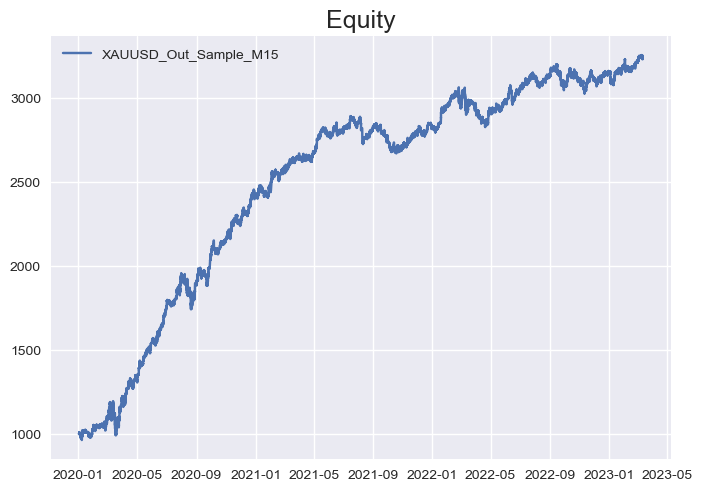

In [63]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [64]:
filename_train = f'result_{TF}_In_Sample.csv'

In [65]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [66]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [67]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [68]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'


In [69]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [70]:
train , test = ml.Run()

### In-Sample Backtesting

In [71]:
train

Start                     2020-05-15 11:15:00
End                       2022-12-30 21:50:00
Duration                    959 days 10:35:00
Exposure Time [%]                   99.998928
Equity Final [$]                     5142.626
Equity Peak [$]                      5213.578
Return [%]                           414.2626
Buy & Hold Return [%]                5.233258
Return (Ann.) [%]                   65.836225
Volatility (Ann.) [%]               17.603515
Sharpe Ratio                         3.739948
Sortino Ratio                       11.683643
Calmar Ratio                         7.033227
Max. Drawdown [%]                   -9.360743
Avg. Drawdown [%]                   -0.145175
Max. Drawdown Duration       40 days 13:15:00
Avg. Drawdown Duration        0 days 07:30:00
# Trades                                96245
Win Rate [%]                        65.882903
Best Trade [%]                          1.128
Worst Trade [%]                     -2.698002
Avg. Trade [%]                    

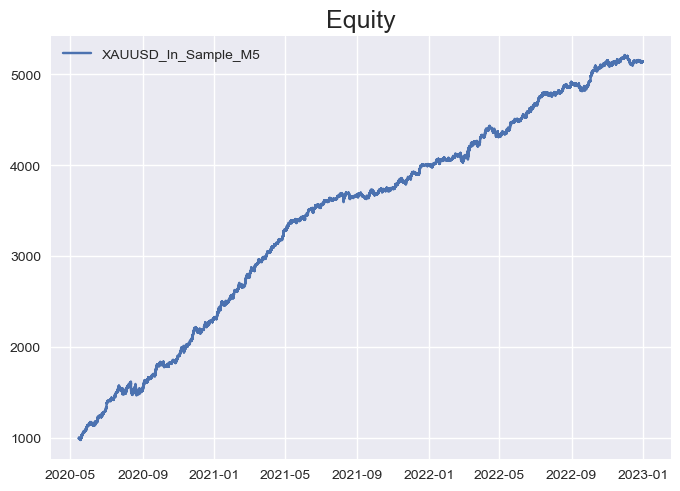

In [72]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [73]:
test

Start                     2023-01-02 23:05:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:50:00
Exposure Time [%]                   99.985069
Equity Final [$]                     1166.623
Equity Peak [$]                      1194.646
Return [%]                            16.6623
Buy & Hold Return [%]                1.902369
Return (Ann.) [%]                   95.832673
Volatility (Ann.) [%]               42.400928
Sharpe Ratio                         2.260155
Sortino Ratio                        7.289837
Calmar Ratio                         9.255214
Max. Drawdown [%]                  -10.354453
Avg. Drawdown [%]                   -0.403596
Max. Drawdown Duration       24 days 17:45:00
Avg. Drawdown Duration        0 days 09:21:00
# Trades                                 6920
Win Rate [%]                        65.895954
Best Trade [%]                       0.473524
Worst Trade [%]                     -1.381982
Avg. Trade [%]                    

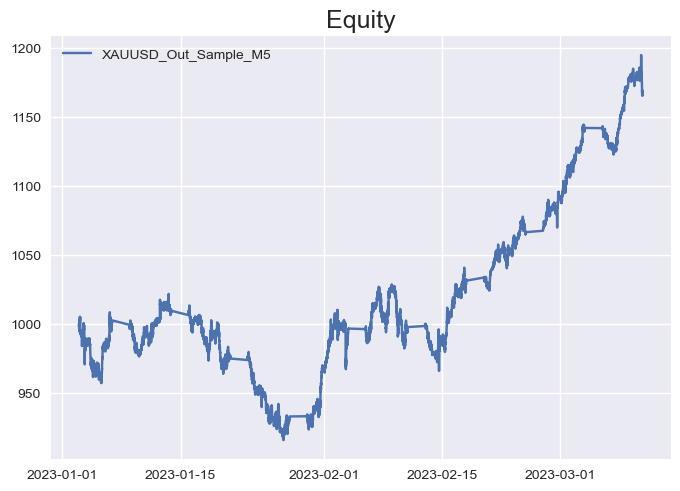

In [74]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [75]:
filename_train = f'result_{TF}_In_Sample.csv'

In [76]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [77]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [78]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [79]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'


In [80]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [81]:
train , test = ml.Run()

### In-Sample Backtesting

In [82]:
train

Start                     2022-08-16 23:14:00
End                       2022-12-30 21:57:00
Duration                    135 days 22:43:00
Exposure Time [%]                   99.998497
Equity Final [$]                      1076.26
Equity Peak [$]                      1177.469
Return [%]                              7.626
Buy & Hold Return [%]                2.660637
Return (Ann.) [%]                   17.260243
Volatility (Ann.) [%]               32.284446
Sharpe Ratio                          0.53463
Sortino Ratio                        1.053756
Calmar Ratio                         0.791185
Max. Drawdown [%]                  -21.815682
Avg. Drawdown [%]                   -0.294962
Max. Drawdown Duration       69 days 23:56:00
Avg. Drawdown Duration        0 days 10:48:00
# Trades                                66419
Win Rate [%]                        62.659781
Best Trade [%]                       1.272465
Worst Trade [%]                     -0.928594
Avg. Trade [%]                    

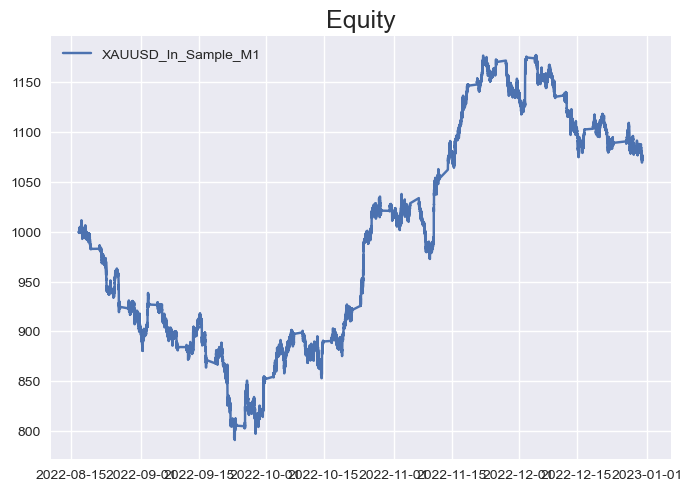

In [83]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [84]:
test

Start                     2023-01-02 23:01:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:58:00
Exposure Time [%]                   99.997013
Equity Final [$]                      931.147
Equity Peak [$]                        1000.0
Return [%]                            -6.8853
Buy & Hold Return [%]                2.056405
Return (Ann.) [%]                  -22.196937
Volatility (Ann.) [%]               24.712877
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -22.3448
Avg. Drawdown [%]                    -22.3448
Max. Drawdown Duration       66 days 18:57:00
Avg. Drawdown Duration       66 days 18:57:00
# Trades                                33510
Win Rate [%]                        62.691734
Best Trade [%]                       0.506454
Worst Trade [%]                     -0.526973
Avg. Trade [%]                    

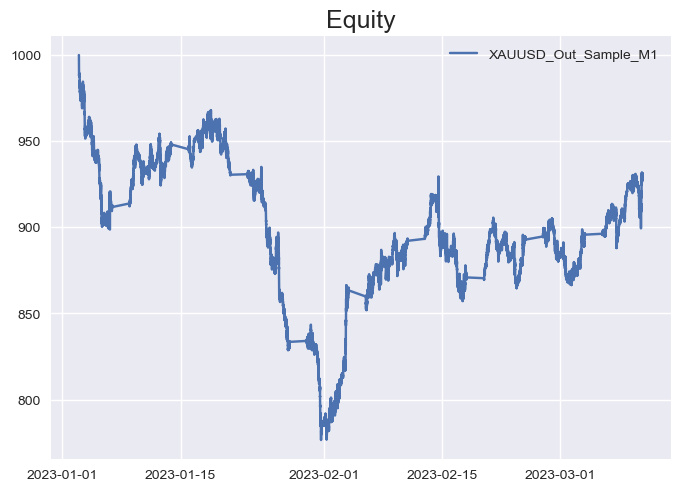

In [85]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [86]:
filename_train = f'result_{TF}_In_Sample.csv'

In [87]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')